<a href="https://colab.research.google.com/github/JUBINBIJU/Vacation/blob/master/proj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import os
import pandas as pd
import tensorflow as tf
import tqdm
import cv2
import matplotlib.pyplot as plt
import keras
from sklearn.model_selection import train_test_split
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from keras.layers import *
from tensorflow.keras.applications import MobileNetV2
from keras import backend as K
from scipy.io import loadmat
from keras.models import Model
from keras.models import model_from_json

In [2]:
def decode_to_boxes(output , ht , wd):
    #output : (x,x,1,5)
    #x,y,h,w

    img_ht = ht
    img_wd = wd
    threshold = 0.5
    grid_h,grid_w = output.shape[:2]
    final_boxes = []
    scores = []

    for i in range(grid_h):
        for j in range(grid_w):
            if output[i,j,0,0] > threshold:

                temp = output[i,j,0,1:5]
                
                x_unit = ((j + (temp[0]))/grid_w)*img_wd
                y_unit = ((i + (temp[1]))/grid_h)*img_ht
                width = temp[2]*img_wd*1.3
                height = temp[3]*img_ht*1.3
                
                final_boxes.append([x_unit - width/2,y_unit - height/2 ,x_unit + width/2,y_unit + height/2])
                scores.append(output[i,j,0,0])
    
    return final_boxes,scores

In [3]:
def iou(box1,box2):

    x1 = max(box1[0],box2[0])
    x2 = min(box1[2],box2[2])
    y1 = max(box1[1] ,box2[1])
    y2 = min(box1[3],box2[3])
    
    inter = (x2 - x1)*(y2 - y1)
    
    area1 = (box1[2] - box1[0])*(box1[3] - box1[1])
    area2 = (box2[2] - box2[0])*(box2[3] - box2[1])
    fin_area = area1 + area2 - inter
        
    iou = inter/fin_area
    
    return iou

In [4]:
def non_max(boxes , scores , iou_num):

    scores_sort = scores.argsort().tolist()
    keep = []
    
    while(len(scores_sort)):
        
        index = scores_sort.pop()
        keep.append(index)
        
        if(len(scores_sort) == 0):
            break
    
        iou_res = []
    
        for i in scores_sort:
            iou_res.append(iou(boxes[index] , boxes[i]))
        
        iou_res = np.array(iou_res)
        filtered_indexes = set((iou_res > iou_num).nonzero()[0])

        scores_sort = [v for (i,v) in enumerate(scores_sort) if i not in filtered_indexes]
    
    final = []
    
    for i in keep:
        final.append(boxes[i])
    return final

In [5]:
def decode(output , ht , wd , iou):  
    boxes , scores = decode_to_boxes(output ,ht ,wd)
    boxes = non_max(boxes,np.array(scores) , iou)
    return boxes

In [6]:
image_path = '/content/drive/MyDrive/proj/images'
gt_path = '/content/drive/MyDrive/proj/ground_truth'
train_image_paths = []
train_gt_paths = []

In [7]:
for new_file in tqdm.tqdm(os.listdir(gt_path)):
    
    name_split = new_file.split('.')
    image_name = name_split[0][3:]
    image_name = image_name + '.jpg'
    
    if 'gt' in new_file:
        image_name = name_split[0][3:]
        image_name = image_name + '.jpg'
    
    path_img = os.path.join(image_path , image_name)
    train_image_paths.append(path_img)
    train_gt_paths.append(os.path.join(gt_path , new_file))

100%|██████████| 461/461 [00:00<00:00, 98400.72it/s]


In [8]:
X_final = []
Y_final = []
grid_h = 16
grid_w = 16
img_w = 512
img_h = 512

In [9]:
for z in tqdm.tqdm(range(len(train_image_paths))):
    
    new_file = train_image_paths[z]
    #print(new_file)
    x = cv2.imread(train_image_paths[z])
    x_sl = 512/x.shape[1]
    y_sl = 512/x.shape[0]
    
    img = cv2.resize(x,(512,512))
    
    
    X_final.append(img)
    
    #plt.imshow(cv2.imread(new_file))
    #plt.show()
    
    i = " "
    
    if 'img' in new_file:
        i = ", "
    
    Y = np.zeros((grid_h,grid_w,1,5))
    
    file = train_gt_paths[z]
    name = open(file , 'r')
    data = name.read()
    data = data.split("\n")
    data = data[:-1]
    
    
    for li in data:
        temp_list = []
        file_data = li.split(i)
        strr = file_data[4]
        bb = file_data[:4]
        
        xmin = int(bb[0])*x_sl
        xmax = int(bb[2])*x_sl
        ymin = int(bb[1])*y_sl
        ymax = int(bb[3])*y_sl
        
        #te = cv2.rectangle(img,(int(xmin),int(ymin)),(int(xmax),int(ymax)) , color = (0,255,0))
        
        w = (xmax - xmin)/img_w
        h = (ymax - ymin)/img_h
        
        x = ((xmax + xmin)/2)/img_w
        y = ((ymax + ymin)/2)/img_h
        x = x * grid_w
        y = y * grid_h
        
        Y[int(y),int(x),0,0] = 1
        Y[int(y),int(x),0,1] = x - int(x)
        Y[int(y),int(x),0,2] = y - int(y)
        Y[int(y),int(x),0,3] = w
        Y[int(y),int(x),0,4] = h
        
    #plt.imshow(te)
    #plt.show()
    
    Y_final.append(Y)

100%|██████████| 461/461 [01:57<00:00,  3.93it/s]


In [10]:
X = np.array(X_final)
X_final = []
Y = np.array(Y_final)
Y_final = []

X = (X - 127.5)/127.5

np.save('/content/drive/MyDrive/proj/X.npy',X)
np.save('/content/drive/MyDrive/proj/Y.npy',Y)

In [11]:
#Variable Definition
img_w = 512
img_h = 512
channels = 3
classes = 1
info = 5
grid_w = 16
grid_h = 16

In [12]:
#import data
#X and Y numpy arrays are created using the Prepocess.py file
X = np.load('/content/drive/MyDrive/proj/X.npy')
Y = np.load('/content/drive/MyDrive/proj/Y.npy')

In [13]:
print(X.shape , Y.shape)

(461, 512, 512, 3) (461, 16, 16, 1, 5)


In [14]:
X_train , X_val , Y_train , Y_val  = train_test_split(X,Y,train_size = 0.75 , shuffle = True)
X = []
Y = []

In [15]:
#define model
# input : 512,512,3
# output : 16,16,1,5

def save_model(model):
    model_json = model.to_json()
    with open("/content/drive/MyDrive/proj/text_detect_model.json", "w") as json_file:
        json_file.write(model_json)

def load_model(strr):        
    json_file = open(strr, 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = model_from_json(loaded_model_json)
    return loaded_model
  
def yolo_model(input_shape):
    
    
    inp = Input(input_shape)
   
    model = MobileNetV2( input_tensor= inp , include_top=False, weights='imagenet')
    last_layer = model.output
    
    conv = Conv2D(512,(3,3) , activation='relu' , padding='same')(last_layer)
    conv = Dropout(0.4)(conv)
    bn = BatchNormalization()(conv)
    lr = LeakyReLU(alpha=0.1)(bn)
    
    conv = Conv2D(128,(3,3) , activation='relu' , padding='same')(lr)
    conv = Dropout(0.4)(conv)
    bn = BatchNormalization()(conv)
    lr = LeakyReLU(alpha=0.1)(bn)
    
    conv = Conv2D(5,(3,3) , activation='relu' , padding='same')(lr)
    
    final = Reshape((grid_h,grid_w,classes,info))(conv)
    
    model = Model(inp,final)
    
    return model

In [16]:
#define utils

#optimizer
opt = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

#checkpoint
checkpoint = ModelCheckpoint('/content/drive/MyDrive/proj/text_detect.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='min',period=1)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [17]:
#define loss function
def yolo_loss_func(y_true,y_pred):
    # y_true : 16,16,1,5
    # y_pred : 16,16,1,5
    l_coords = 5.0
    l_noob = 0.5
    coords = y_true[:,:,:,:,0] * l_coords
    noobs = (-1*(y_true[:,:,:,:,0] - 1)*l_noob)
    p_pred = y_pred[:,:,:,:,0]
    p_true = y_true[:,:,:,:,0]
    x_true = y_true[:,:,:,:,1]
    x_pred = y_pred[:,:,:,:,1]
    yy_true = y_true[:,:,:,:,2]
    yy_pred = y_pred[:,:,:,:,2]
    w_true = y_true[:,:,:,:,3]
    w_pred = y_pred[:,:,:,:,3]
    h_true = y_true[:,:,:,:,4]
    h_pred = y_pred[:,:,:,:,4]
    
    p_loss_absent = K.sum(K.square(p_pred - p_true)*noobs)
    p_loss_present = K.sum(K.square(p_pred - p_true))
    x_loss = K.sum(K.square(x_pred - x_true)*coords)
    yy_loss = K.sum(K.square(yy_pred - yy_true)*coords)
    xy_loss = x_loss + yy_loss
    w_loss = K.sum(K.square(K.sqrt(w_pred) - K.sqrt(w_true))*coords)
    h_loss = K.sum(K.square(K.sqrt(h_pred) - K.sqrt(h_true))*coords)
    wh_loss = w_loss + h_loss
    
    loss = p_loss_absent + p_loss_present + xy_loss + wh_loss
    
    return loss

In [18]:
#load and save model
input_size = (img_h,img_w,channels)

model = yolo_model(input_size)

print(model.summary())

save_model(model)

9420800/9406464 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 256, 256, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 256, 256, 32  128         ['Conv1[0][0]']                  
                               

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


In [19]:
model.load_weights('/content/drive/MyDrive/proj/text_detect.h5')

In [20]:
model.compile(loss=yolo_loss_func , optimizer=opt , metrics = ['accuracy'])

In [21]:
hist = model.fit(X_train ,Y_train ,epochs= 30 ,batch_size = 4 , callbacks=[checkpoint] , validation_data=(X_val,Y_val))

Epoch 1/30
87/87 [==============================] - ETA: 0s - loss: 2.3709 - accuracy: 0.0549
Epoch 00001: val_loss improved from inf to 2.65031, saving model to /content/drive/MyDrive/proj/text_detect.h5


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


87/87 [==============================] - 49s 369ms/step - loss: 2.3709 - accuracy: 0.0549 - val_loss: 2.6503 - val_accuracy: 0.0663
Epoch 2/30
87/87 [==============================] - ETA: 0s - loss: 2.3335 - accuracy: 0.0541
Epoch 00002: val_loss did not improve from 2.65031
87/87 [==============================] - 28s 326ms/step - loss: 2.3335 - accuracy: 0.0541 - val_loss: 2.8909 - val_accuracy: 0.0606
Epoch 3/30
87/87 [==============================] - ETA: 0s - loss: 2.3322 - accuracy: 0.0527
Epoch 00003: val_loss did not improve from 2.65031
87/87 [==============================] - 28s 325ms/step - loss: 2.3322 - accuracy: 0.0527 - val_loss: 2.9140 - val_accuracy: 0.0697
Epoch 4/30
87/87 [==============================] - ETA: 0s - loss: 2.2595 - accuracy: 0.0562
Epoch 00004: val_loss did not improve from 2.65031
87/87 [==============================] - 28s 325ms/step - loss: 2.2595 - accuracy: 0.0562 - val_loss: 2.9168 - val_accuracy: 0.0598
Epoch 5/30
87/87 [===================

In [22]:
model = load_model('/content/drive/MyDrive/proj/text_detect_model.json')
model.load_weights('/content/drive/MyDrive/proj/text_detect.h5')

In [23]:
def predict_func(model , inp , iou , name):

    ans = model.predict(inp)
    
    #np.save('Results/ans.npy',ans)
    boxes = decode(ans[0] , img_w , img_h , iou)
    
    img = ((inp + 1)/2)
    img = img[0]
    #plt.imshow(img)
    #plt.show()

    for i in boxes:
        i = [int(x) for x in i]
        img = cv2.rectangle(img , (i[0] ,i[1]) , (i[2] , i[3]) , color = (0,255,0) , thickness = 2)
    plt.imshow(img)
    plt.show()
    cv2.imwrite(os.path.join('Results' , str(name) + '.jpg') , img*255.0)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


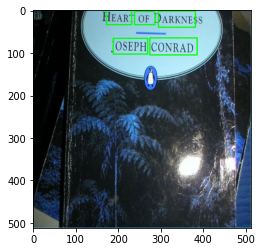

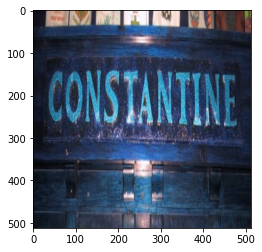

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


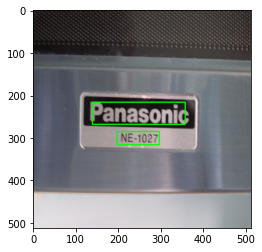

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


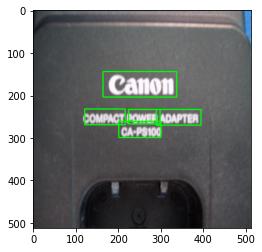

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


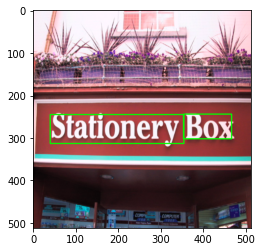

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


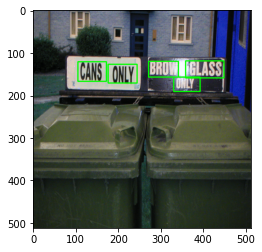

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


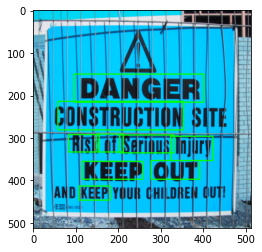

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


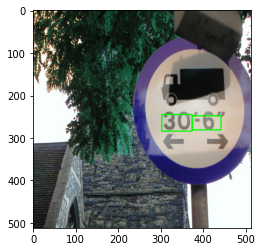

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


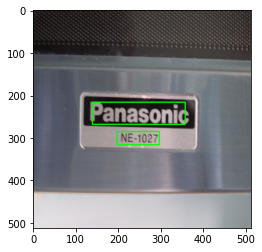

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


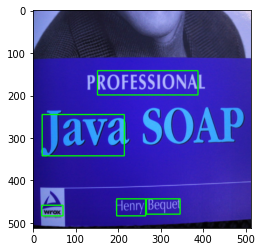

In [24]:
rand = np.random.randint(0,X_val.shape[0], size = 10)

for i in rand:
    predict_func(model , X_val[i:i+1] , 0.5, i)
    

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


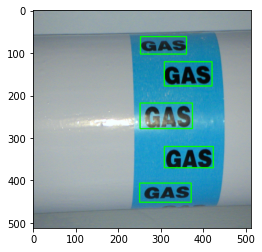

In [26]:
for i in os.listdir('/content/drive/MyDrive/proj/Test'):
    img = cv2.imread(os.path.join('/content/drive/MyDrive/proj/Test',i))
    img = cv2.resize(img,(512,512))
    img = (img - 127.5)/127.5
    predict_func(model , np.expand_dims(img,axis= 0) , 0.5 , 'sample')